In [1]:
import json
from collections import Counter
import re
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from razdel import tokenize
import torch
from transformers import AutoModel, AutoTokenizer
from rouge import Rouge
from sklearn.metrics.pairwise import cosine_similarity
from easse.sari import corpus_sari

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = Path("../data")

WIKI_DIR = DATA_DIR / "WikiSimple-translated"
PARAPHRASER_PATH = DATA_DIR / "ParaPhraserPlus" / "ParaPhraserPlus.json"

DEV_PATH = DATA_DIR / "dev_sents.csv"
TEST_PATH = DATA_DIR / "public_test_only.csv"

# Отбор по длине

In [3]:
def get_word_tokens(text):
    tokens = re.sub(r"[^\w\s]", "", text).split()
    tokens = [t.lower() for t in tokens]
    return tokens

## dev, test

In [9]:
# dev
dev_df = pd.read_csv(DEV_PATH, index_col=0)
dev_df.columns = ["input", "output"]

# test
with open(TEST_PATH) as f:
    test_df = pd.DataFrame({"input": [line.strip() for line in f.readlines()]})
test_df["output"] = ""

In [12]:
dev_df["input"].value_counts().sort_values(ascending=False)

Используемый алгоритм имеет определённую временную сложность, поэтому перед оптимизацией кода программы стоит сначала пересмотреть алгоритм.                           5
В последнем матче группового этапа против сборной Венгрии Роналду оформил дубль и отдал голевую передачу.                                                              5
Писателю показался забавным также факт, что мать Каменской, тоже акушерка, когда-то принимала новорождённого Пешкова.                                                  5
Впервые появилась возможность провести прямое сравнение генотипа императора с генотипом обнаруженных под Екатеринбургом останков.                                      5
Зачастую Цезарь принимал решение не совещаясь с сенатом, хотя при публичном оглашении текста закона указывалось, будто сенаторы поддержали диктатора.                  5
                                                                                                                                                           

In [5]:
dev_df.groupby("input")["output"].apply(list).reset_index()

,input,output
0,1960 году была выпущена модель 172A. Изменени...,[В 1960 году вышла модель 172А. Отличие в хвос...
1,14 декабря 1944 года рабочий посёлок Ички был ...,[14 декабря 1944 года рабочий посёлок Ички пер...
2,26 августа 2014 года Болдок принял участие в п...,[26 августа 2014 года Болдок выиграл футбольны...
3,Armory — клиент с различными функциями для пов...,[Armory - программа с различными функциями для...
4,Concert for Diana (рус. Концерт для Дианы) — к...,"[Concert for Diana - это концерт, посвящённый ..."
...,...,...
995,Эффективность азитромицина при лечении инфекци...,[Азитромицин показал свою эффективность в лече...
996,Юг и среднюю часть республики занимают горы и ...,"[Часть республики занимают горы, а часть низме..."
997,Юго-Восточное побережье — Феодосийский и Судак...,"[Весь Крым находится под охраной государства.,..."
998,Язгуля́мский язы́к (самоназвание — Yuzdami zev...,"[Язгулямский язык - один из языков, на котором..."


In [6]:
dev_df.groupby("input")["output"].apply(list).reset_index()["input"].to_csv(DATA_DIR / "dev_input_only.csv",
                                                                            index=False, header=None)

In [8]:
# одинаковые input и output
dev_df[dev_df["input"] == dev_df["output"]]

,input,output
1345,В примере выше могут произойти ошибки при прео...,В примере выше могут произойти ошибки при прео...
1489,В своём выступлении по радио президент Египта ...,В своём выступлении по радио президент Египта ...
1529,В сельскохозяйственных областях в первые месяц...,В сельскохозяйственных областях в первые месяц...
3185,Желающим предлагалось снять пятиминутное видео...,Желающим предлагалось снять пятиминутное видео...
4436,"Местами сохранились стальные кольца, вделанные...","Местами сохранились стальные кольца, вделанные..."
4520,"Многие думали, что Маршалл просто не выпустит ...","Многие думали, что Маршалл просто не выпустит ..."
4585,"Могут применяться также гемодиализ, парнополяр...","Могут применяться также гемодиализ, парнополяр..."
7483,Пришедшие к власти монтаньяры столкнулись с др...,Пришедшие к власти монтаньяры столкнулись с др...
7535,"Происходят взаимные этнические чистки, начинае...","Происходят взаимные этнические чистки, начинае..."
9477,"Форпост был построен на правом берегу Ишима, г...","Форпост был построен на правом берегу Ишима, г..."


In [9]:
sample = dev_df.sample()

for col in ["input", "output"]:
    text = sample[col].item()
    print(col, "\n", text)

input 
 Переосмысление революционных событий и судьбы России сопровождалось для Блока глубоким творческим кризисом, депрессией и прогрессирующей болезнью.
output 
 У Блока был творческий кризис, депрессия и болезнь из-за революции и беспокойства за судьбы России.


In [10]:
for df in [dev_df, test_df]:
    for col in df:
        df[f"{col}_tokens"] = df[col].apply(get_word_tokens)
        df[f"{col[:3]}_len"] = df[f"{col}_tokens"].apply(len)

In [11]:
dev_df["n_common_tokens"] = dev_df.apply(lambda x: len(set(x["input_tokens"]) & set(x["output_tokens"])), axis=1)

In [12]:
n = 0
n_examples = (dev_df["n_common_tokens"] == n).sum()
print(f"N of examples with {n} common tokens: {n_examples}, share: {n_examples / dev_df.shape[0]:.3f}")

sample = dev_df[dev_df["n_common_tokens"] == n].sample()

for col in ["input", "output"]:
    text = sample[col].item()
    print(col, "\n", text)

N of examples with 0 common tokens: 29, share: 0.009
input 
 Обозреватель издания назвал сценарий виртуозным и непредсказуемым, способным удержать на одном плане сразу две дюжины героев.
output 
 Журналист похвалил фильм.


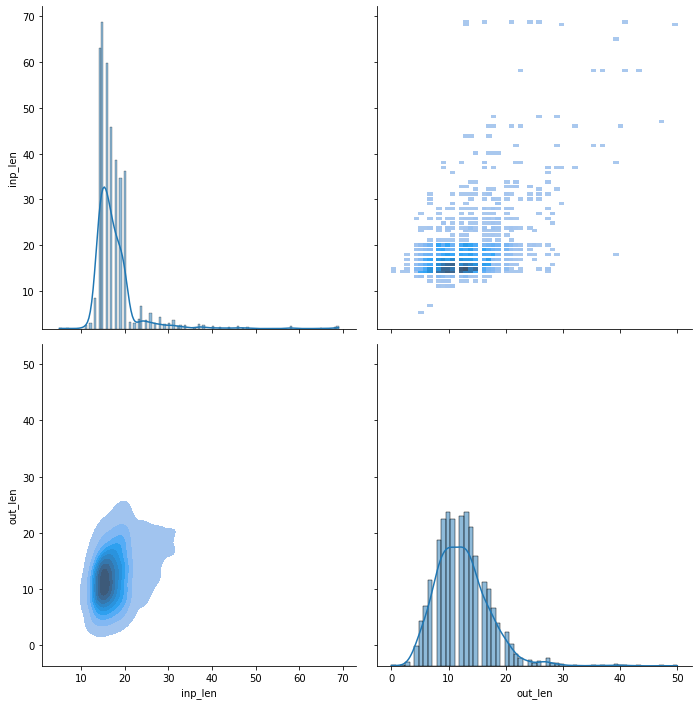

In [13]:
g = sns.PairGrid(dev_df[["inp_len", "out_len"]], height=5)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True);

In [ ]:
# sns.displot(dev_df, x="inp_len", y="out_len", height=8);
# sns.jointplot(data=dev_df, x="inp_len", y="out_len", alpha=0.3);
# sns.jointplot(data=dev_df, x="inp_len", y="out_len", kind="reg");

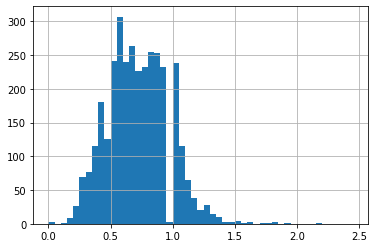

In [14]:
(dev_df["out_len"] / dev_df["inp_len"]).hist(bins=np.arange(0, 2.5, 0.05));

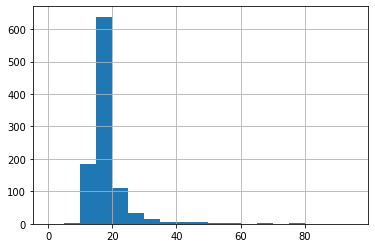

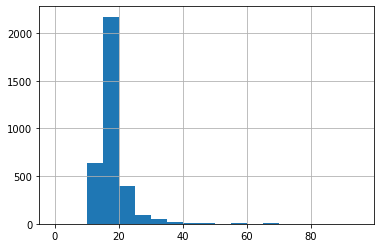

In [15]:
test_df["inp_len"].hist(bins=np.arange(0, 100, 5))
plt.show()
dev_df["inp_len"].hist(bins=np.arange(0, 100, 5))
plt.show()

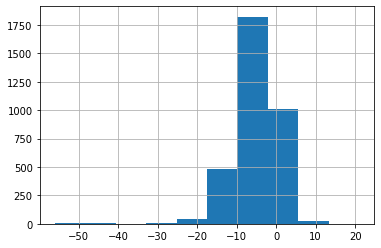

In [16]:
# разница длин output и input
(dev_df["out_len"] - dev_df["inp_len"]).hist();

In [17]:
# доля примеров, где out длиннее in в токенах
((dev_df["out_len"] / dev_df["inp_len"]) > 1).mean()

0.09277745155607751

In [18]:
# доля примеров, где out длиннее in в токенах
((dev_df["out_len"] / dev_df["inp_len"]) > 1.06).mean()

0.07868467410452143

In [19]:
sample = dev_df[
    ((dev_df["out_len"] / dev_df["inp_len"]) > 1.0)
    & ((dev_df["out_len"] / dev_df["inp_len"]) < 1.2)
].sample()

for col in ["input", "output"]:
    print(sample[col].item(), "\n")

Взрыв не состоялся по нелепой причине: один из заговорщиков, не имея часов, опоздал занять позицию ко времени проезда императора. 

Взрыв не состоялся из-за того, что один из заговорщиков не имел часов и опоздал знать позицию ко времени проезда императора. 



In [20]:
sample = dev_df[
    ((dev_df["out_len"] / dev_df["inp_len"]) > 1.3)
#     & ((dev_df["out_len"] / dev_df["inp_len"]) < np.inf)
].sample()

for col in ["input", "output"]:
    print(sample[col].item(), "\n")

Голубой цвет на флаге является традиционным цветом тюркских народов и символизирует тюркство, красный — прогресса, зелёный — ислама. 

На флаге есть голубой цвет, он показывает, что люди говорят на тюркском языке. Красный цвет на флаге показывает развитие людей. Зеленый цвет на флаге показывает на мусульманскую религию. 



## Wiki

In [6]:
dfs = [pd.read_csv(path, usecols=["target_x", "target_y"]) for path in WIKI_DIR.glob("*")]
wiki_df = pd.concat(dfs).reset_index(drop=True)
wiki_df.columns = ["input", "output"]

In [7]:
wiki_df.shape

(248111, 2)

In [8]:
# года (в регулярке просто цифры) внутри скобок
wiki_df[wiki_df["input"].apply(lambda x: bool(re.match(r".*\(.*\d+.*\)", x)))]

,input,output
18,Томас Гравесен (родился 11 марта 1976 года) - ...,Томас Гравесен (родился 11 марта 1976 года) - ...
27,Экономика Это диаграмма тренда региональной ва...,Экономика Это диаграмма тенденции региональной...
30,Мэтью Перри (род. 1969) - канадско-американски...,"Мэтью Перри (актер) (1969 г.р.), американский ..."
44,При высоте 140 см (55 дюймов) журавль не может...,При высоте 55 дюймов журавль не может стать ле...
75,Рудольф Вальтер Рихард Гесс (по-немецки HeÃ) (...,Вальтер Ричард Рудольф Гесс (HeÃ по-немецки) (...
...,...,...
247947,"Самовар и Портер (1994), стр. 84 сирийца не со...","Самовар и Портер (1994), стр. 84 сирийца не со..."
247967,Иэн Грив (родился 19 февраля 1987 года в Джван...,Иэн Грив (родился 19 февраля 1987 года в Джван...
248009,Сен-Мартен - тропический остров на северо-вост...,Сен-Мартен - тропический остров на северо-вост...
248013,Приблизительно в зависимости от численности па...,В зависимости от силы каждой партии в Федераль...


In [24]:
sample = wiki_df.sample()

for col in sample:
    text = sample[col].item()
    print(col, "\n", text)

input 
 Вернувшись в «Нэшнл», теперь на Южном берегу, его следующим поворотным моментом стала премьерная постановка Питера Холла «Предательства Гарольда Пинтера», неожиданно тонкий спектакль - на производственной фотографии он обнимает Пенелопу Уилтон чувствительными руками и длинными тонкими пальцами ( прикосновение мастера-часовщика).
output 
 Вернувшись в «Нэшнл», теперь на Южном берегу, его следующим поворотным моментом стала премьерная постановка Питером Холлом «Предательства Гарольда Пинтера», неожиданно утонченный спектакль - на производственной фотографии он обнимает Пенелопу Уилтон чувствительными руками и длинными стройными руками. пальцы (прикосновение мастера-часовщика).


In [25]:
for col in wiki_df:
    wiki_df[f"{col}_tokens"] = wiki_df[col].apply(get_word_tokens)
    wiki_df[f"{col[:3]}_len"] = wiki_df[f"{col}_tokens"].apply(len)

In [26]:
wiki_df["n_common_tokens"] = wiki_df.apply(lambda x: len(set(x["input_tokens"]) & set(x["output_tokens"])), axis=1)

In [27]:
n = 3
n_examples = (wiki_df["n_common_tokens"] == n).sum()
print(f"N of examples with {n} common tokens: {n_examples}, share: {n_examples / wiki_df.shape[0]:.3f}")

sample = wiki_df[wiki_df["n_common_tokens"] == n].sample()

for col in ["input", "output"]:
    text = sample[col].item()
    print(col, "\n", text)

N of examples with 3 common tokens: 14221, share: 0.057
input 
 Этот флаг города Винсеннес, штат Индиана, хотя и несколько неофициальный, используется в нескольких районах города.
output 
 Винсеннес - город в штате Индиана в США.


In [28]:
# выбираем >= 3 общих токенов и output / input <= 1.2 и output > 3

n = 3
wiki_df_part = wiki_df[
    (wiki_df["n_common_tokens"] >= n)
    & (wiki_df["out_len"] / wiki_df["inp_len"] <= 1.2)
    & (wiki_df["out_len"] > 3)
]
n_examples = wiki_df_part.shape[0]

print(f"N of examples with >= {n} common tokens and output / input <= 1.2: {n_examples}, share: {n_examples / wiki_df.shape[0]:.3f}")

sample = wiki_df_part.sample()

for col in ["input", "output"]:
    text = sample[col].item()
    print(col, "\n", text)

N of examples with >= 3 common tokens and output / input <= 1.2: 174367, share: 0.703
input 
 В возрасте пятнадцати лет Мэри была обручена со своим двоюродным братом, протестантским штатгальтером Голландии Вильгельмом Оранским.
output 
 Когда ей было 15 лет, леди Мэри обручилась со своим двоюродным братом, протестантом Уильямом, принцем Оранским.


In [29]:
# остальные невошедшие

sample =  wiki_df.loc[wiki_df.index.difference(wiki_df_part.index)].sample()

for col in ["input", "output"]:
    text = sample[col].item()
    print(col, "\n", text)

input 
 Это живая и раскованная вариация Jitterbug, разновидности свинг-танца.
output 
 Это живая и непринужденная вариация более ранних форм свинг-танца, таких как Jitterbug.


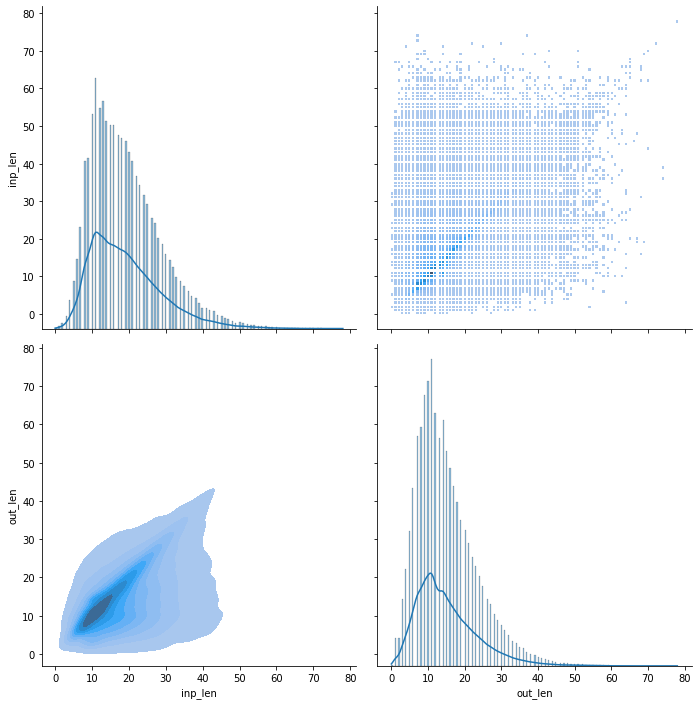

In [30]:
g = sns.PairGrid(wiki_df[["inp_len", "out_len"]], height=5)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True);

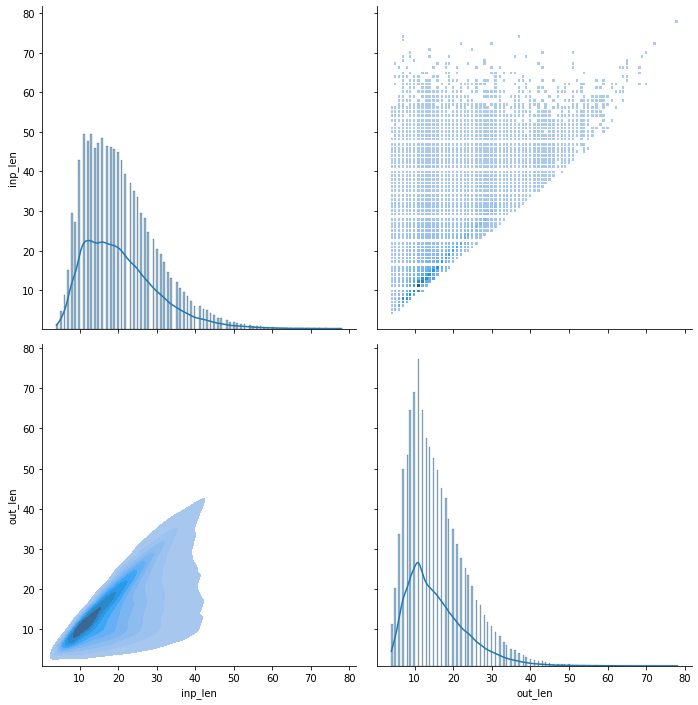

In [31]:
g = sns.PairGrid(wiki_df_part[["inp_len", "out_len"]], height=5)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True);

In [105]:
wiki_df_part[["input", "output"]].to_csv(DATA_DIR / "prepared_data" / "wiki_part.csv", index=False)

## Headlines

In [13]:
with open(PARAPHRASER_PATH) as f:
    titles = json.load(f)

In [14]:
len(titles)

1725393

In [21]:
titles["19"]

{'rubric': 'происшествия',
 'date': '2019/01/02',
 'headlines': ['При пожаре в общежитии Нижнего Тагила погибли двое мужчин',
  'Два человека погибли в результате пожара в общежитии в Нижнем Тагиле',
  'В Нижнем Тагиле два человека погибли при пожаре в общежитии',
  'При пожаре в общежитии в Нижнем Тагиле погибли два человека']}

In [17]:
from collections import Counter

In [20]:
Counter([len(i["headlines"]) for i in titles.values()])

Counter({2: 698548,
         3: 332557,
         4: 198145,
         7: 74575,
         6: 99496,
         5: 135604,
         11: 23077,
         8: 56912,
         9: 42693,
         13: 9597,
         10: 31781,
         14: 4800,
         12: 16243,
         15: 1365})

In [34]:
Counter(titles[k]["rubric"] for k in titles)

Counter({'общество': 371109,
         'спорт': 192182,
         'региональные': 174090,
         'происшествия': 325432,
         'конфликты': 3663,
         'зарубежные': 83763,
         'политика': 285048,
         'наука': 18429,
         'культура': 15419,
         'экономика': 227740,
         'события': 13891,
         'медиа': 3243,
         'авто': 7824,
         'жкх': 3359,
         'здоровье': 200,
         'животные': 1})

In [36]:
# выбираем самый длинный headline как input, и остальные как output, если они короче его > чем на 2

def select_headlines(headlines_lst):
    result = []
    (long_headline, long_len), *other_headlines = sorted(
        [(text, len(get_word_tokens(text))) for text in headlines_lst], key=lambda x: -x[1]
    )
    for headline, len_ in other_headlines:
        if long_len - len_ > 2:
            result.append([long_headline, headline, long_len, len_])
    return result

In [43]:
sample = titles[str(np.random.choice(len(titles)))]["headlines"]
print(*sorted([(text, len(get_word_tokens(text))) for text in sample], key=lambda x: -x[1]), sep="\n")
select_headlines(sample)

('Решение о снятии карантина в иркутских школах примут 13 февраля', 10)
('Карантин в школах Иркутска снимут 14 февраля', 7)


[['Решение о снятии карантина в иркутских школах примут 13 февраля',
  'Карантин в школах Иркутска снимут 14 февраля',
  10,
  7]]

In [44]:
# без спорта
headlines_lst = []
for k in tqdm(titles):
    if titles[k]["rubric"] in ["спорт"]:
        continue
    headlines = titles[k]["headlines"]
    result = select_headlines(headlines)
    if result:
        headlines_lst.append(result)

headlines_lst = [row for lst in headlines_lst for row in lst]

headlines_df = pd.DataFrame(headlines_lst, columns=["input", "output", "inp_len", "out_len"])

  0%|          | 0/1725393 [00:00<?, ?it/s]

In [46]:
headlines_df["diff"] = headlines_df["inp_len"] - headlines_df["out_len"]

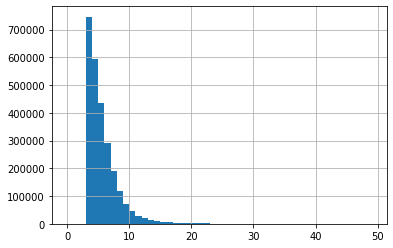

In [48]:
headlines_df["diff"].hist(bins=np.arange(0, 50, 1));

In [134]:
# итого + без "курс" в строке, и разницей между input output > 4 и < 20

headlines_df = headlines_df[
    ~((headlines_df["input"].str.lower().str.contains("курс"))
     | (headlines_df["output"].str.lower().str.contains("курс"))
     | (headlines_df["input"].str.lower().str.contains("{")))
    & (headlines_df["diff"] > 4)
    & (headlines_df["diff"] < 20)
].reset_index(drop=True)

In [135]:
# сэмплируем 250к примеров
headlines_sample_df = headlines_df.sample(250000, random_state=19)

In [144]:
sample = headlines_sample_df.sample()
for col in ["input", "output"]:
    text = sample[col].item()
    print(col, "\n", text)

input 
 Следствие по делу Пусси Райт завершено и направлено в прокуратуру для утверждения
output 
 Дело Pussy Riot передано в прокуратуру


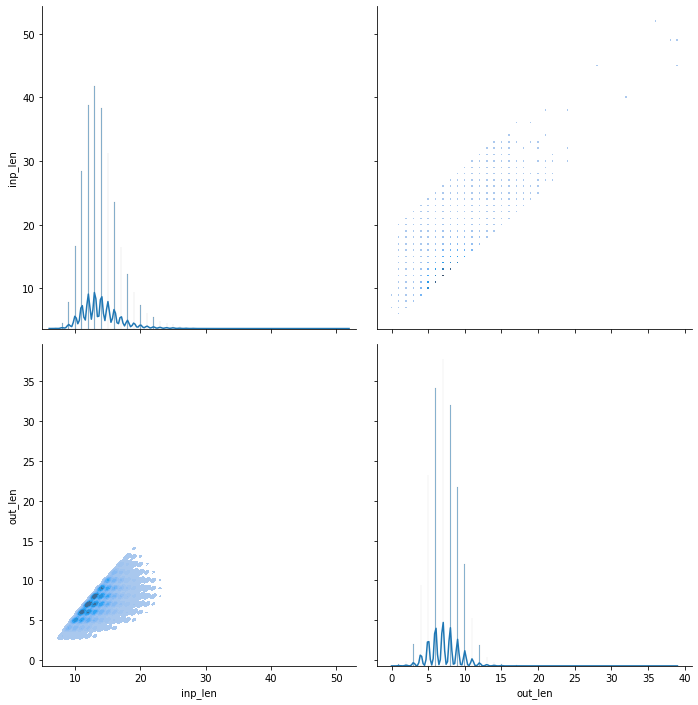

In [145]:
g = sns.PairGrid(headlines_sample_df[["inp_len", "out_len"]], height=5)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True);

In [148]:
headlines_sample_df[["input", "output"]].to_csv(DATA_DIR / "prepared_data" / "headlines_sample.csv", index=False)

## Combine

In [149]:
# добавляем 250к заголовков к отобранному wiki

combined_df = pd.concat([wiki_df_part[["input", "output"]],
                         headlines_sample_df[["input", "output"]]]).sample(frac=1, random_state=19).reset_index(drop=True)

In [163]:
sample = combined_df.sample()
for col in ["input", "output"]:
    text = sample[col].item()
    print(col, "\n", text)

input 
 Последний человек, который, как известно, имел прямое происхождение от Линкольна, внук Роберта Бад Беквит умер в 1985 году.
output 
 Последним человеком, который имел прямое отношение к Линкольну, был внук Роберта Бад Беквит. Он умер в 1985 году.


In [166]:
combined_df[["input", "output"]].to_csv(DATA_DIR / "prepared_data" / "combined_df.csv", index=False)

# Отбор по косинусной близости и rouge-L

In [4]:
MAX_LENGTH = 200

In [5]:
def get_word_tokens(text):
    tokens = re.sub(r"[^\w\s]", "", text).split()
    tokens = [t.lower() for t in tokens]
    return tokens

In [6]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [7]:
def get_similarities(model, tokenizer, input_texts, output_texts):
    # Tokenize sentences
    encoded_input = tokenizer(input_texts, padding=True, truncation=True,
                              max_length=MAX_LENGTH, return_tensors='pt').to(model.device)
    encoded_output = tokenizer(output_texts, padding=True, truncation=True,
                              max_length=MAX_LENGTH, return_tensors='pt').to(model.device)

    # Compute token embeddings
    with torch.no_grad():
        model_emb_input = model(**encoded_input)
        model_emb_output = model(**encoded_output)

    # Perform pooling. In this case, mean pooling
    input_embeddings = mean_pooling(model_emb_input, encoded_input['attention_mask']).cpu()
    output_embeddings = mean_pooling(model_emb_output, encoded_output['attention_mask']).cpu()
    similarity = cosine_similarity(input_embeddings, output_embeddings)
    return similarity

In [8]:
def get_rougel(input_text, output_text):
    """
    Returns rouge-l f-score
    """
    rouge = Rouge()
    scores = []
    # try/except because of empty output or just dot (in dev_sents)
    try:
        score = rouge.get_scores(input_text, output_text)[0]
        score = score["rouge-l"]["f"]
    except ValueError:  
        score = 0.0
    return score

In [9]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
model.to("cuda")

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(120138, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fal

## dev, test

In [9]:
# dev
dev_df = pd.read_csv(DEV_PATH, index_col=0)
dev_df.columns = ["input", "output"]

# test
with open(TEST_PATH) as f:
    test_df = pd.DataFrame({"input": [line.strip() for line in f.readlines()]})
test_df["output"] = ""

In [10]:
%%time
dev_df["cosine_sim"] = dev_df.apply(lambda x: get_similarities(model, tokenizer, x["input"], x["output"]),
                                    axis=1)
dev_df["cosine_sim"] = dev_df["cosine_sim"].apply(lambda x: x[0][0])

CPU times: user 1min 36s, sys: 115 ms, total: 1min 36s
Wall time: 1min 36s


In [11]:
%%time
dev_df["rouge_l"] = dev_df.apply(lambda x: get_rougel(x["input"], x["output"]), axis=1)

CPU times: user 884 ms, sys: 0 ns, total: 884 ms
Wall time: 882 ms


In [12]:
dev_df["input_len"] = dev_df["input"].apply(lambda x: len(get_word_tokens(x)))
dev_df["output_len"] = dev_df["output"].apply(lambda x: len(get_word_tokens(x)))

In [27]:
dev_df.to_csv(DATA_DIR / "prepared_data" / "dev_df_metrics.csv", index=False)

In [140]:
dev_df = pd.read_csv(DATA_DIR / "prepared_data" / "dev_df_metrics.csv")

In [141]:
dev_df.sort_values("cosine_sim")

,input,output,cosine_sim,rouge_l,input_len,output_len
2890,Среди болезней кошек выделяют инфекционные и в...,.,-0.037777,0.000000,15,0
2535,"Пробыв в заключении около года, мурза попыталс...",.,0.065845,0.000000,14,0
1635,На цирковых представлениях изображение Цезаря ...,управления и не нужно было искать новые способ...,0.365181,0.086957,14,11
1197,"Известно, что полководца и царицу сопровождали...",Страна готовится наконец отдохнуть от 2020 год...,0.386948,0.000000,18,15
970,До начала весеннего наступления оставалось нес...,"Все ссоры скоро кончатся, потому что начнется ...",0.461736,0.074074,19,8
...,...,...,...,...,...,...
406,В примере выше могут произойти ошибки при прео...,В примере выше могут произойти ошибки при прео...,1.000000,1.000000,15,15
1533,"Могут применяться также гемодиализ, парнополяр...","Могут применяться также гемодиализ, парнополяр...",1.000000,1.000000,20,20
3222,"Форпост был построен на правом берегу Ишима, г...","Форпост был построен на правом берегу Ишима, г...",1.000000,1.000000,14,14
599,Вариант интерпретатора с синхронизацией доступ...,Вариант интерпретатора с синхронизацией доступ...,1.000000,0.972973,18,18


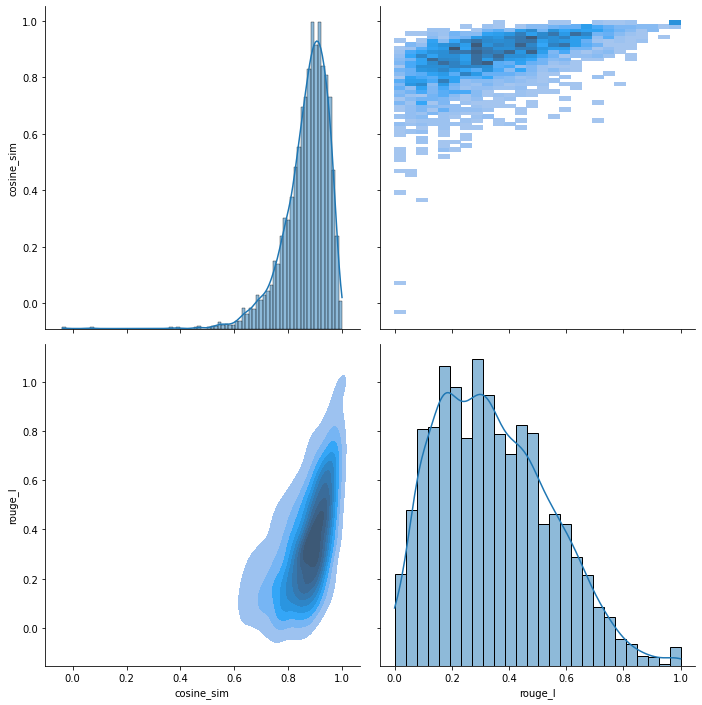

In [14]:
g = sns.PairGrid(dev_df[["cosine_sim", "rouge_l"]], height=5)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True);

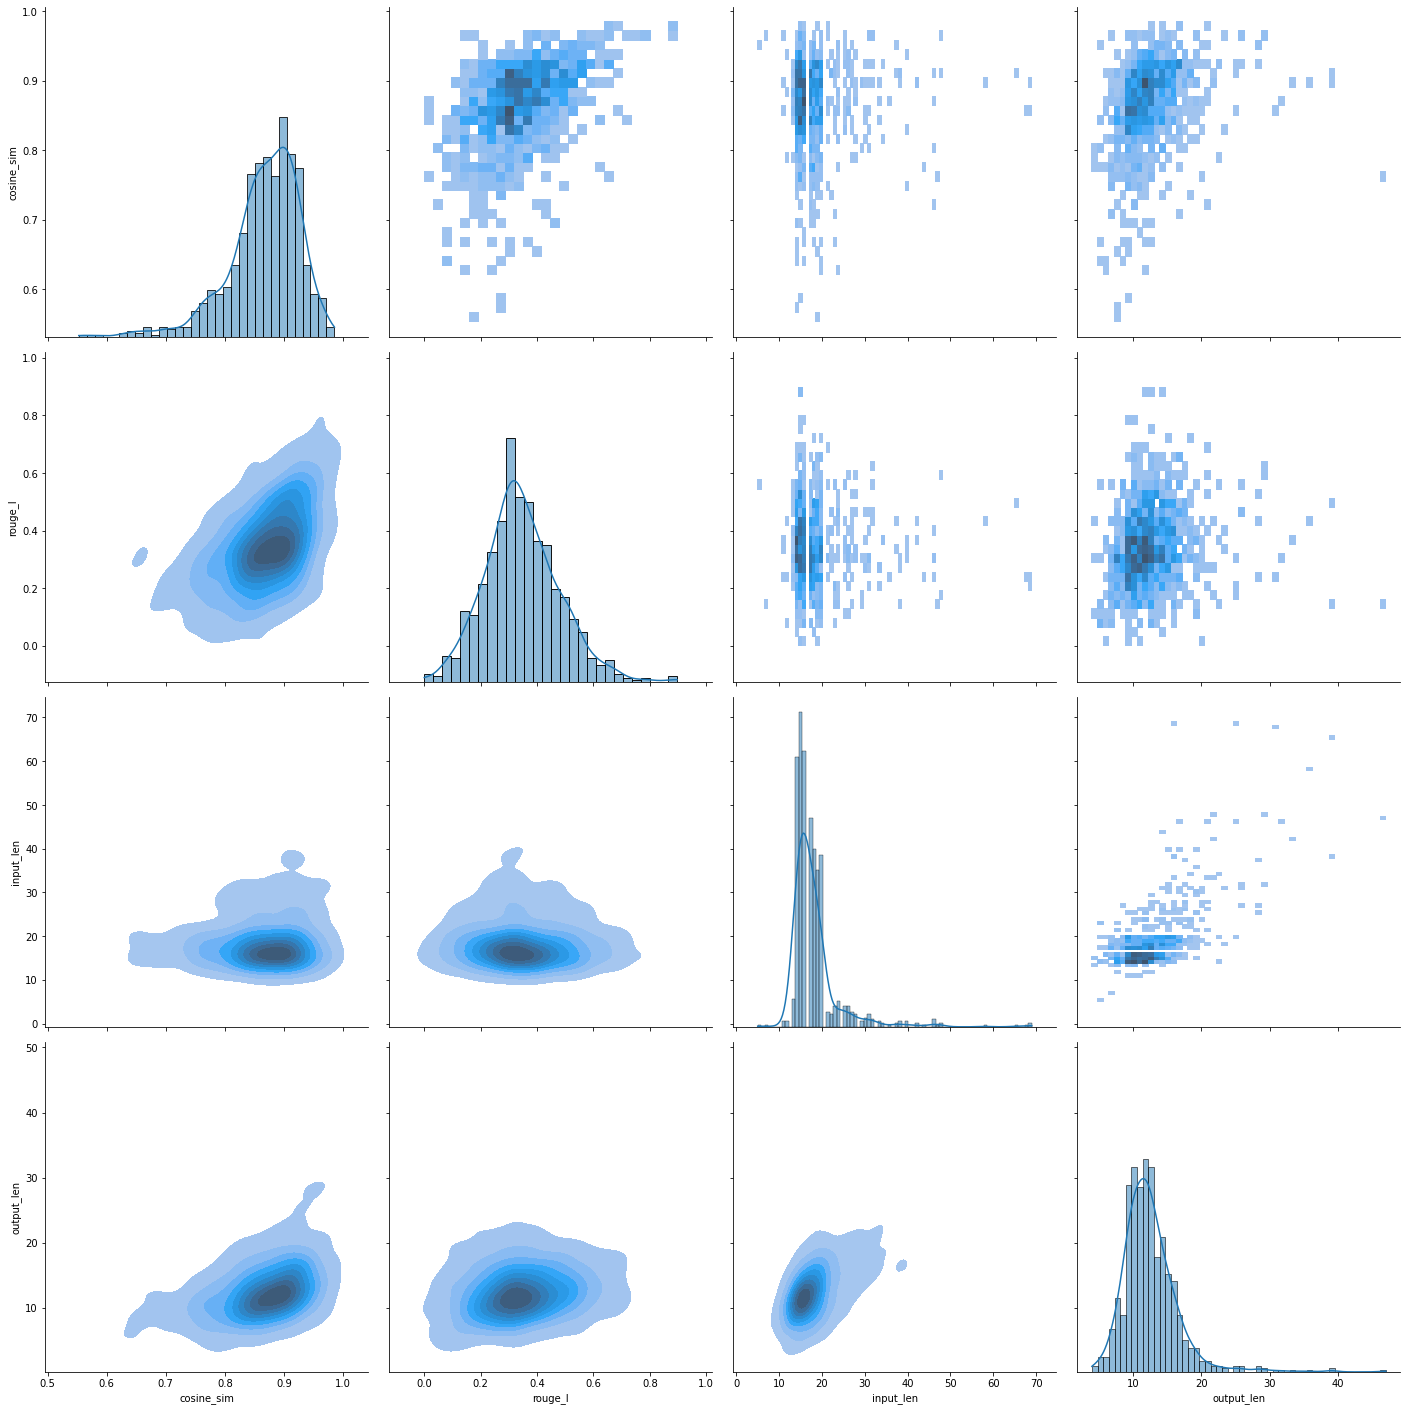

In [15]:
# сгруппированный по input и средние значения
g = sns.PairGrid(dev_df.groupby("input").apply(np.mean), height=5)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True);

In [17]:
dev_df_grouped = dev_df.groupby("input").agg(
    {"output": list, "cosine_sim": list, "rouge_l": list, "input_len": np.mean, "output_len": list}
).reset_index()
dev_df_grouped

,input,output,cosine_sim,rouge_l,input_len,output_len
0,1960 году была выпущена модель 172A. Изменени...,[В 1960 году вышла модель 172А. Отличие в хвос...,"[0.8730071783065796, 0.8468641042709351, 0.723...","[0.35294117153979243, 0.3124999951757813, 0.60...",20,"[17, 14, 14, 19]"
1,14 декабря 1944 года рабочий посёлок Ички был ...,[14 декабря 1944 года рабочий посёлок Ички пер...,[0.9206905961036682],[0.6428571382653062],20,[10]
2,26 августа 2014 года Болдок принял участие в п...,[26 августа 2014 года Болдок выиграл футбольны...,"[0.8274444937705994, 0.9261506199836731]","[0.5777777729777778, 0.6222222174222223]",28,"[18, 18]"
3,Armory — клиент с различными функциями для пов...,[Armory - программа с различными функциями для...,[0.924230694770813],[0.5454545404648761],20,[23]
4,Concert for Diana (рус. Концерт для Дианы) — к...,"[Concert for Diana - это концерт, посвящённый ...","[0.8712961673736572, 0.8228520154953003, 0.875...","[0.3703703655418381, 0.319999995392, 0.3999999...",15,"[10, 9, 8]"
...,...,...,...,...,...,...
995,Эффективность азитромицина при лечении инфекци...,[Азитромицин показал свою эффективность в лече...,"[0.9227253198623657, 0.6798684597015381, 0.837...","[0.5714285664540818, 0.10526315457063723, 0.35...",15,"[13, 4, 13, 8, 13]"
996,Юг и среднюю часть республики занимают горы и ...,"[Часть республики занимают горы, а часть низме...","[0.7854164242744446, 0.9339486956596375]","[0.2727272683884298, 0.39999999520000007]",16,"[7, 9]"
997,Юго-Восточное побережье — Феодосийский и Судак...,"[Весь Крым находится под охраной государства.,...","[0.6608866453170776, 0.8181402087211609, 0.882...","[0.2857142816326531, 0.35714285216836733, 0.47...",14,"[6, 13, 10, 12, 7]"
998,Язгуля́мский язы́к (самоназвание — Yuzdami zev...,"[Язгулямский язык - один из языков, на котором...","[0.9207618236541748, 0.9567684531211853]","[0.388888883904321, 0.5294117597750866]",18,"[17, 15]"


## Wiki

In [18]:
dfs = [pd.read_csv(path, usecols=["target_x", "target_y"]) for path in WIKI_DIR.glob("*")]
wiki_df = pd.concat(dfs).reset_index(drop=True)
wiki_df.columns = ["input", "output"]

In [19]:
wiki_df.shape

(248111, 2)

In [22]:
%%time
wiki_df["cosine_sim"] = wiki_df.apply(lambda x: get_similarities(model, tokenizer, x["input"], x["output"]),
                                    axis=1)
wiki_df["cosine_sim"] = wiki_df["cosine_sim"].apply(lambda x: x[0][0])

CPU times: user 2h 27s, sys: 5.82 s, total: 2h 33s
Wall time: 2h 32s


In [23]:
%%time
wiki_df["rouge_l"] = wiki_df.apply(lambda x: get_rougel(x["input"], x["output"]), axis=1)

CPU times: user 1min 19s, sys: 32 ms, total: 1min 19s
Wall time: 1min 19s


In [24]:
wiki_df["input_len"] = wiki_df["input"].apply(lambda x: len(get_word_tokens(x)))
wiki_df["output_len"] = wiki_df["output"].apply(lambda x: len(get_word_tokens(x)))

In [28]:
wiki_df.to_csv(DATA_DIR / "prepared_data" / "wiki_df_metrics.csv", index=False)

In [35]:
wiki_df.sort_values("cosine_sim")

,input,output,cosine_sim,rouge_l,input_len,output_len
10144,Фильм был выпущен в Северной Америке 30 сентяб...,.,-0.052350,0.0,13,0
47971,"Структура Фейстеля имеет то преимущество, что ...","RC6,",-0.040000,0.0,23,1
71341,Совсем недавно кладистический анализ предполаг...,?,-0.031931,0.0,14,0
26601,Сомнение ставит под сомнение некоторое понятие...,Я ему нравлюсь?,-0.006886,0.0,25,3
22335,Термин Baja Bug обычно относится к оригинально...,Бага сегодня,-0.001724,0.0,30,2
...,...,...,...,...,...,...
187298,Большая часть западных и северо-восточных Внеш...,Большая часть западных и северо-восточных Внеш...,1.000000,1.0,15,15
71873,Спортсмены из Западной Германии (ФРГ) и Восточ...,Спортсмены из Западной Германии (ФРГ) и Восточ...,1.000000,1.0,27,27
174986,Каждому игроку дается четыре фишки определенно...,Каждому игроку дается четыре фишки определенно...,1.000000,1.0,7,7
192586,Галерея была основана в 1897 году как Национал...,Галерея была основана в 1897 году как Национал...,1.000000,1.0,11,11


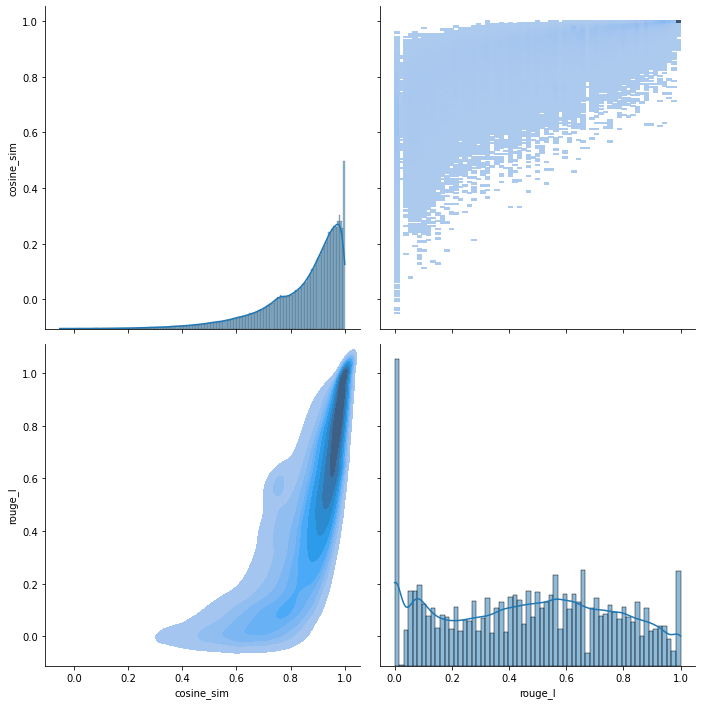

In [34]:
g = sns.PairGrid(wiki_df[["cosine_sim", "rouge_l"]], height=5)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True);

In [35]:
wiki_df = pd.read_csv(DATA_DIR / "prepared_data" / "wiki_df_metrics.csv")

In [36]:
wiki_df_part = wiki_df[
    (wiki_df["cosine_sim"] < 0.99)
  & (wiki_df["cosine_sim"] > 0.6)
  & (wiki_df["rouge_l"] < 0.8)
  & (wiki_df["rouge_l"] > 0.1)
  & (wiki_df["output_len"] <= wiki_df["input_len"])
#   & ~(wiki_df["input"].str.contains("\("))
#   & ~(wiki_df["output"].str.contains("\("))
]

In [53]:
wiki_df_part[["input", "output"]].to_csv(DATA_DIR / "prepared_data" / "wiki_part_sim.csv", index=False)

In [54]:
wiki_df_part.sort_values("cosine_sim")

,input,output,cosine_sim,rouge_l,input_len,output_len
140405,Слово каури также часто используется для обозн...,Ребра каури позволяли игле легче проникать под...,0.600027,0.111111,10,8
177595,"По данным переписи 2000 года, в городе прожива...",Крофордсвилль - город в штате Индиана в США.,0.600101,0.111111,11,7
174555,25 мая 2005 года Андервуд был коронован победи...,Она выиграла четвертый сезон American Idol.,0.600137,0.222222,12,6
9904,"Она немного умела читать и писать, но была нам...",Они считались гораздо более необходимыми для ж...,0.600143,0.413793,23,7
110920,Осирис временами считался старшим сыном бога З...,Он был братом и мужем Исиды.,0.600152,0.222222,25,6
...,...,...,...,...,...,...
158060,Усики (единственное число: антенна) - это парн...,Усики (единственная антенна) - это парные отро...,0.989973,0.800000,12,11
188744,"Слева вверху - розы графов Аренбургских, справ...","Вверху слева - розы графов Аренбургских, вверх...",0.989976,0.764706,20,20
235335,"Файетт - город в округе Фейет, штат Айова, в США.",Файетт - город в штате Айова в США.,0.989980,0.625000,9,7
217138,"СА упск - город в Поморском воеводстве, в севе...",СА упск - город на севере Польши в Поморском в...,0.989982,0.600000,10,9


In [56]:
print(*wiki_df_part.sample().values, sep="\n")

['Изначально Before I Self Destruct планировалось сделать альбомом 50 Cent 2007 года, для которого он подтвердил, что уже закончил двенадцать песен.'
 'Before I Self Destruct - четвертый альбом 50 Cent.' 0.7065908908843994
 0.3999999958 21 8]


## Headlines

In [10]:
with open(PARAPHRASER_PATH) as f:
    titles = json.load(f)

In [11]:
len(titles)

1725393

In [33]:
titles["19"]

{'rubric': 'происшествия',
 'date': '2019/01/02',
 'headlines': ['При пожаре в общежитии Нижнего Тагила погибли двое мужчин',
  'Два человека погибли в результате пожара в общежитии в Нижнем Тагиле',
  'В Нижнем Тагиле два человека погибли при пожаре в общежитии',
  'При пожаре в общежитии в Нижнем Тагиле погибли два человека']}

In [12]:
Counter(titles[k]["rubric"] for k in titles)

Counter({'общество': 371109,
         'спорт': 192182,
         'региональные': 174090,
         'происшествия': 325432,
         'конфликты': 3663,
         'зарубежные': 83763,
         'политика': 285048,
         'наука': 18429,
         'культура': 15419,
         'экономика': 227740,
         'события': 13891,
         'медиа': 3243,
         'авто': 7824,
         'жкх': 3359,
         'здоровье': 200,
         'животные': 1})

In [13]:
# выбираем самый длинный headline как input, и остальные как output, если они короче его > чем на 3

def select_headlines(headlines_lst):
    result = []
    (long_headline, long_len), *other_headlines = sorted(
        [(text, len(get_word_tokens(text))) for text in headlines_lst], key=lambda x: -x[1]
    )
    for headline, len_ in other_headlines:
        if long_len - len_ > 3:
            result.append([long_headline, headline, long_len, len_])
    return result

In [28]:
sample = titles[str(np.random.choice(len(titles)))]["headlines"]
print(*sorted([(text, len(get_word_tokens(text))) for text in sample], key=lambda x: -x[1]), sep="\n")
select_headlines(sample)

('Две российские команды обогнали всех в эстафете на Кубке мира по лыжам', 12)
('Российские лыжники обошли норвежцев', 4)


[['Две российские команды обогнали всех в эстафете на Кубке мира по лыжам',
  'Российские лыжники обошли норвежцев',
  12,
  4]]

In [31]:
# без спорта и новостей с упоминанием "курса" (в основном про валюты)
headlines_lst = []
for k in tqdm(titles):
    if titles[k]["rubric"] in ["спорт"]:
        continue
    elif any("курс" in headline.lower() for headline in titles[k]["headlines"]):
        continue
    headlines = titles[k]["headlines"]
    result = select_headlines(headlines)
    if result:
        headlines_lst.append(result)

headlines_lst = [row for lst in headlines_lst for row in lst]

headlines_df = pd.DataFrame(headlines_lst, columns=["input", "output", "input_len", "output_len"])

  0%|          | 0/1725393 [00:00<?, ?it/s]

In [57]:
headlines_df

,input,output,input_len,output_len
0,Куриное Рождество в 2019 году: что это за праз...,"Птичий праздник: Что такое ""куриное рождество""...",15,10
1,В Индии 5 млн женщин выстроились стеной в 620 ...,В Индии женщины встали живой стеной длиной 620 км,13,9
2,Снег и порывистый ветер. Синоптики рассказали ...,"Снег, метель и морозец обещают синоптики на 3 ...",13,9
3,Снег и порывистый ветер. Синоптики рассказали ...,"Атмосферные фронты принесут снег, ожидается ух...",13,7
4,Потери на Донбассе: из-за обстрелов боевиков о...,"На Донбассе погиб один военнослужащий ВСУ, еще...",13,9
...,...,...,...,...
1800152,Четыре ведущих российских банка предоставили м...,Российские банки предоставили Белоруссии 6 млр...,33,7
1800153,Четыре ведущих российских банка предоставили м...,Российские банки дали Белоруссии 6 млрд рублей,33,7
1800154,Четыре ведущих российских банка предоставили м...,Четыре российских банка выдали предновогодний ...,33,7
1800155,Четыре ведущих российских банка предоставили м...,Российские банки предоставили Беларуси кредит,33,5


In [59]:
%%time
headlines_df["cosine_sim"] = headlines_df.apply(
    lambda x: get_similarities(model, tokenizer, x["input"], x["output"]), axis=1
)
headlines_df["cosine_sim"] = headlines_df["cosine_sim"].apply(lambda x: x[0][0])

CPU times: user 15h 8min 53s, sys: 52.2 s, total: 15h 9min 45s
Wall time: 15h 9min 51s


In [61]:
%%time
headlines_df["rouge_l"] = headlines_df.apply(lambda x: get_rougel(x["input"], x["output"]), axis=1)

CPU times: user 5min 6s, sys: 472 ms, total: 5min 7s
Wall time: 5min 7s


In [63]:
headlines_df = headlines_df[["input", "output", "cosine_sim", "rouge_l", "input_len", "output_len"]]

In [64]:
headlines_df.to_csv(DATA_DIR / "prepared_data" / "headlines_df_metrics.csv", index=False)

In [65]:
headlines_df.sort_values("cosine_sim")

,input,output,cosine_sim,rouge_l,input_len,output_len
1749199,Страны G8 готовы выделить $15 млрд за 3 года н...,G,0.029937,0.000000,15,1
610041,"""Спартак"" - ""Торпедо"": прогноз на матч КХЛ 24 ...",vfgf,0.064244,0.000000,15,1
1684527,ОППОЗИЦИЯ ПРОСИТ МЕДВЕДЕВА ЗАЩИТИТЬ ХОДОРКОВСКОГО,7.0,0.065270,0.000000,5,1
1216717,"""Единая Россия"": парламентское расследование н...",Так нельзя,0.077708,0.000000,10,2
1473918,Первой моделью Е-мобиля на новом заводе в Санк...,Е-моебили,0.100088,0.000000,10,1
...,...,...,...,...,...,...
1004469,"""Нафтогаз"" перечислил ""Газпрому"" $1,45 млрд в ...","""Нафтогаз"" перечислил ""Газпрому"" $1,45 млрд по...",0.994722,0.818182,13,9
1741428,На ФБ ММВБ цена облигации Аркада-03 упала на 4...,На ФБ ММВБ цена облигации Аркада-03 упала на 2...,0.994842,0.764706,20,16
1729895,На ФБ ММВБ цена облигации ИнкомЛада2 упала на ...,На ФБ ММВБ цена облигации ИнкомЛада3 упала на ...,0.994968,0.705882,20,16
1583915,Великобритания. Сальдо торгового баланса без у...,Великобритания. Сальдо торгового баланса в дек...,0.995033,0.685714,20,16


In [112]:
headlines_df_part = headlines_df[
    (headlines_df["cosine_sim"] < 0.99)
  & (headlines_df["cosine_sim"] > 0.8)
  & (headlines_df["rouge_l"] < 0.8)
  & (headlines_df["rouge_l"] > 0.1)
  & (headlines_df["output_len"] <= headlines_df["input_len"])
  & (headlines_df["input"].apply(lambda x: not bool(re.search(r"\d", x))))  # без цифр
  & (headlines_df["output"].apply(lambda x: not bool(re.search(r"\d", x))))
]

In [146]:
headlines_df_part.sort_values("cosine_sim")

,input,output,cosine_sim,rouge_l,input_len,output_len
756635,В результате обстрела Андреевки и Дзержинска р...,Боевики обстреливают окрестности Дзержинска,0.800000,0.133333,10,4
1727327,"Премьер-министр Италии: Мировой кризис - это ""...","Берлускони назвал финансовый кризис ""американс...",0.800001,0.105263,12,6
686333,Постановление О представлении Президенту Росси...,На подпись Путину представлен договор о союзни...,0.800001,0.200000,21,12
114783,"Соединенные штаты не выводят войска из Сирии, ...",США не собираются выводить войска из Сирии,0.800001,0.333333,11,7
475903,Соколов: авиасообщение с Хургадой и Шарм-эш-Ше...,Соколов назвал маловероятным возобновление ави...,0.800001,0.300000,12,8
...,...,...,...,...,...,...
261666,Средний платеж по налогу на имущество вырос бо...,Средний платеж по налогу на имущество вырос вдвое,0.987623,0.700000,12,8
1232745,Иран начал военные учения для защиты ядерных о...,Иран начал учения по защите ядерных объектов о...,0.987744,0.666667,14,10
385854,США начали поставки оружия сирийским курдам дл...,США начали поставки оружия сирийским курдам,0.987774,0.750000,10,6
646497,Коалиция США не подтверждает сообщения о гибел...,Коалиция США не подтверждает гибель иракских в...,0.987863,0.583333,14,10


In [114]:
headlines_df_part[["input", "output"]].to_csv(DATA_DIR / "prepared_data" / "headlines_part_sim.csv", index=False)

In [171]:
print(*headlines_df_part.sample().values)

['Путин подписал закон о создании свободной экономической зоны в Крыму и Севастополе'
 'Путин подписал закон о создании СЭЗ в Крыму' 0.9600304365158081
 0.6999999952000001 12 8]


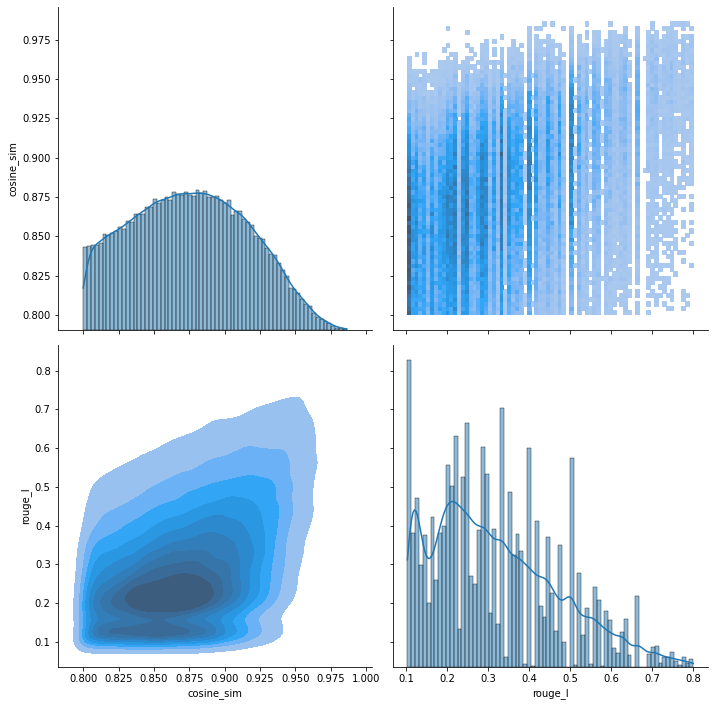

In [195]:
g = sns.PairGrid(headlines_df_part[["cosine_sim", "rouge_l"]].sample(100000), height=5)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True);

## Combine

In [163]:
wiki_df_part = pd.read_csv(DATA_DIR / "prepared_data" / "wiki_part_sim.csv")

In [172]:
combined_df = pd.concat([wiki_df_part[["input", "output"]],
                         headlines_df_part[["input", "output"]]]).reset_index(drop=True)

In [173]:
combined_df

,input,output
0,"Он заявил, что зоопарк нарушил законодательств...","Он заявил, что зоопарк нарушает правила защиты..."
1,Британская транспортная комиссия (BTC) была со...,Британская транспортная комиссия (BTC) была со...
2,Отношения Фицджеральда с Гранцем еще больше ук...,"Затем Гранц стал ее менеджером, но он не запис..."
3,"Этот сезон был выше среднего, потому что было ...","В этом сезоне было 14 названных штормов, 10 ур..."
4,Кюбрис - это коммуна в департаменте Приморские...,Cu bris - это коммуна.
...,...,...
829056,Аферист века Бернард Мэдофф вернулся из тюремн...,Бернард Мэдофф вернулся в свою камеру
829057,Центральная площадь Нью-Йорка была эвакуирован...,Таймс-сквер в Нью-Йорке эвакуирован. Угроза те...
829058,Центральная площадь Нью-Йорка была эвакуирован...,Таймс-сквер эвакуирована из-за подозрительного...
829059,По подозрению в нападении на реставратора Жура...,Возможные убийцы реставратора Янтарной комнаты...


In [ ]:
sample = combined_df.sample()
for col in ["input", "output"]:
    text = sample[col].item()
    print(col, "\n", text)

In [181]:
combined_df[["input", "output"]].to_csv(DATA_DIR / "prepared_data" / "combined_df_sim.csv", index=False)